# Linear Regression

This notebook contains extremely detailed comments explaining each line and function used.
It is designed for learning and reproducibility.

🔹 Regression Problem Statement (Salary Prediction)

In this use case, we aim to predict an employee’s salary based on multiple features such as age, years of experience, department, education level, certifications, performance score, remote work percentage, and bonus. Since salary is a continuous numeric variable, this is a regression problem. The objective is to build a model (using Linear Regression) that captures how different factors influence salary levels. The insights will help organizations in understanding compensation patterns, ensuring fairness, and designing effective salary structures aligned with employee attributes and performance.

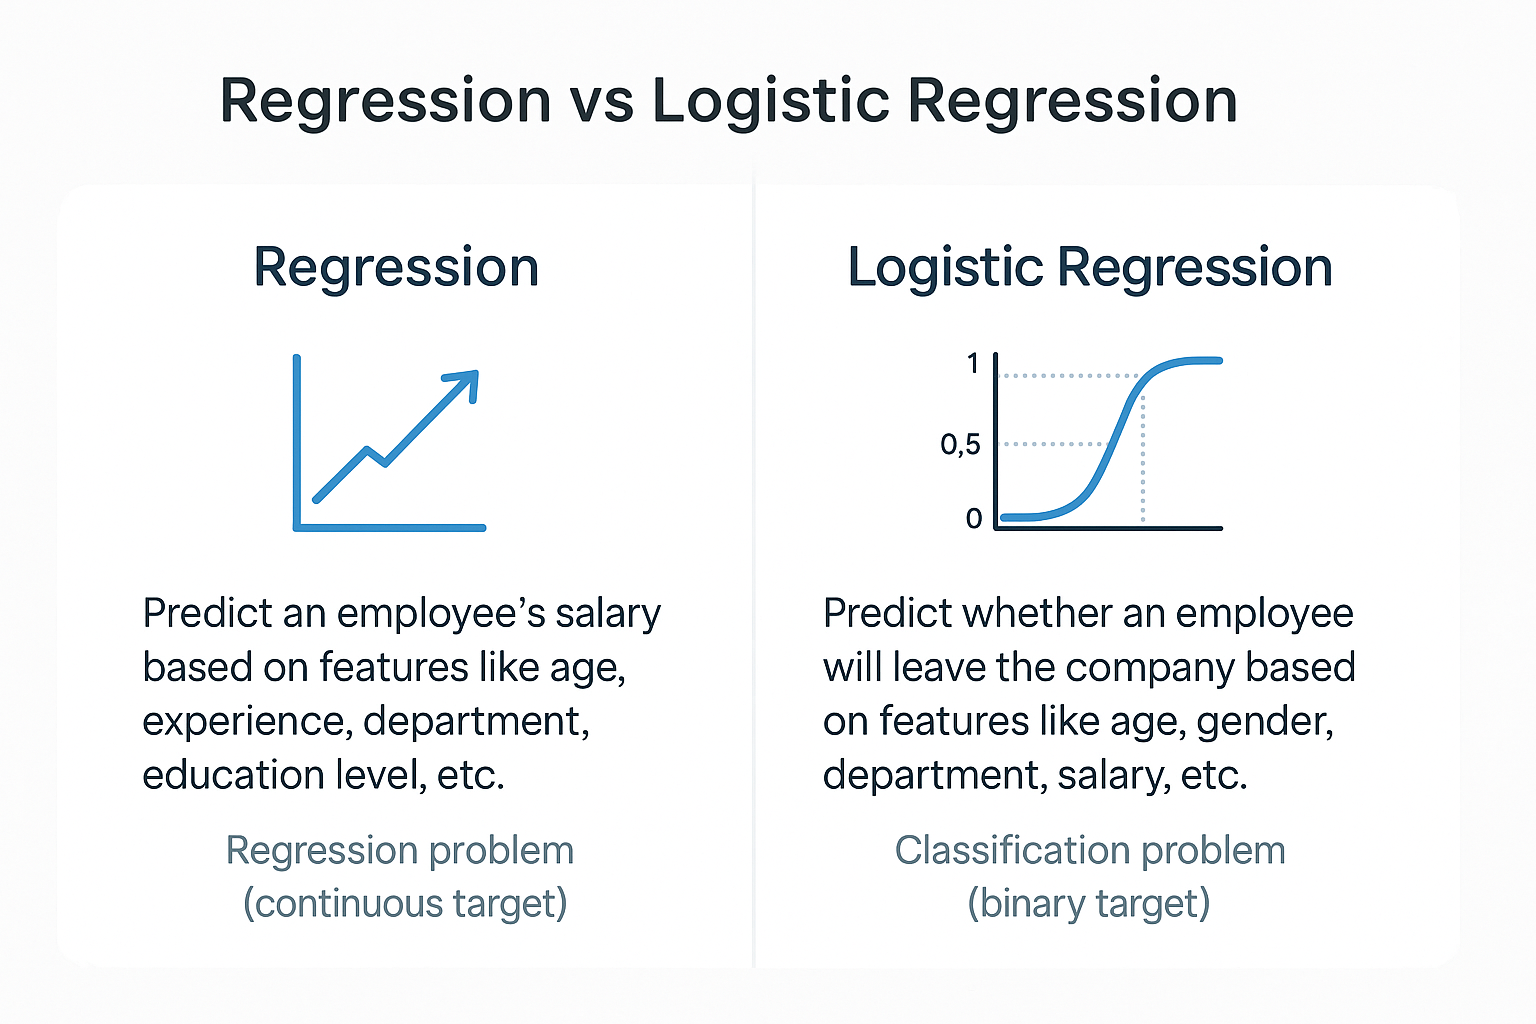

In [ ]:
!pip install -r requirements.txt

In [1]:

# pandas (pd) provides DataFrame data structures and data manipulation utilities.
import pandas as pd  # pd.DataFrame, pd.read_csv, pd.to_datetime, etc.

# numpy (np) provides numerical operations, random number generation, and arrays.
import numpy as np  # np.array, np.random, arithmetic operations

# matplotlib.pyplot for plotting (low-level plotting API). We use it for fine control.
import matplotlib.pyplot as plt  # plt.figure, plt.plot, plt.show

# seaborn is a statistical plotting library built on matplotlib; it provides high-level plot functions.
import seaborn as sns  # sns.histplot, sns.boxplot, sns.heatmap, sns.scatterplot

# pathlib.Path for file path manipulations in an OS-independent way.
from pathlib import Path  # Path('folder') to manage filesystem paths

# sklearn utilities for modeling: preprocessing, model, and metrics.
from sklearn.model_selection import train_test_split  # splitting data into train/test sets
from sklearn.preprocessing import StandardScaler  # feature scaling (zero mean, unit variance)
from sklearn.linear_model import LinearRegression  # ordinary least squares linear model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # evaluation metrics

# joblib to save/load trained models efficiently.
import joblib  # joblib.dump, joblib.load

# Set plotting style for seaborn (makes plots look nicer by default).
sns.set_theme(style='whitegrid')

# Make plots appear inline in Jupyter notebooks (magic - only in notebooks).
%matplotlib inline

# Define data and output directories using Path for convenience and portability.
BASE_DIR = Path('')  # current working directory
DATA_PATH = Path('sample_input_for_regression.csv')  # the CSV we saved earlier
OUTPUT_DIR = Path('output')  # folder to write cleaned data and models
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # create output folder if it doesn't exist


In [2]:
#!pip install -U pandas

In [3]:
# Explanation: Load dataset from CSV into a pandas DataFrame.
# We set parse_dates for 'hire_date' to automatically convert to datetime dtype.
df = pd.read_csv(DATA_PATH, parse_dates=['hire_date'])  # pd.read_csv reads CSV into DataFrame

# Show the number of rows and columns (shape): (rows, columns)
print('Shape:', df.shape)

# Display the first few rows for a quick sanity check. display() is Jupyter-friendly.
display(df.head())

# Show data types for each column so we can detect incorrect types (e.g., strings representing dates)
print('\nData types:') 
print(df.dtypes)


Shape: (500, 11)


,id,age,years_experience,department,education_level,certifications,performance_score,remote_work_pct,bonus,hire_date,salary
0,1,24,2.0,Finance,PhD,1,3.50,0,6490.0,2009-11-29,68622
1,2,50,13.0,HR,Bachelors,2,3.29,100,14567.0,2016-12-18,84421
2,3,56,22.0,Sales,Bachelors,1,3.89,40,6214.0,2018-05-06,98333
3,4,60,23.0,HR,Bachelors,0,3.12,20,13092.0,2014-01-20,101913
4,5,39,9.0,IT,Bachelors,2,2.77,40,10858.0,2017-07-16,70554



Data types:
id                            int64
age                           int64
years_experience            float64
department                   object
education_level              object
certifications                int64
performance_score           float64
remote_work_pct               int64
bonus                       float64
hire_date            datetime64[ns]
salary                        int64
dtype: object


In [4]:
# Explanation: Quick overview (missing values, basic stats) and cleaning steps.
# 1) Missing values: count per column
print('Missing values per column:\n', df.isnull().sum())  # isnull() -> boolean mask; sum() counts True (=NaN)

# 2) Basic numeric statistics (count, mean, std, min, quartiles, max)
print('\nNumeric summary:\n', df.describe().T)  # describe() summarizes numeric columns

# 3) Categorical columns frequency check (value_counts)
print('\nCategorical value counts:') 
for col in ['department','education_level']:
    print(f'\n-- {col} --') 
    print(df[col].value_counts(dropna=False))  # value_counts shows frequency of each category (including NaN)

# 4) Duplicates: check and drop if any exact duplicate rows exist
dupes = df.duplicated().sum()  # duplicated() marks duplicate rows after the first occurrence
print('\nDuplicate rows found:', dupes)
if dupes > 0:
    df = df.drop_duplicates()  # drop_duplicates removes exact duplicate rows

# 5) Convert 'hire_date' to datetime if not already (defensive programming)
if not np.issubdtype(df['hire_date'].dtype, np.datetime64):
    df['hire_date'] = pd.to_datetime(df['hire_date'], errors='coerce')  # errors='coerce' sets invalid parsing to NaT

# 6) Impute missing numeric columns with median (robust to outliers)
for col in ['years_experience','bonus','performance_score']:
    if col in df.columns:
        median_val = df[col].median()  # median is robust central tendency measure
        df[col] = df[col].fillna(median_val)  # fillna replaces NaN with median

print('\nMissing values after median imputation:\n', df.isnull().sum())

# 7) Final quick check
display(df.head())


Missing values per column:
 id                    0
age                   0
years_experience     25
department            0
education_level       0
certifications        0
performance_score    25
remote_work_pct       0
bonus                25
hire_date             0
salary                0
dtype: int64

Numeric summary:
                    count          mean           std      min       25%  \
id                 500.0    250.500000    144.481833      1.0    125.75   
age                500.0     41.066000     11.324404     22.0     31.00   
years_experience   475.0      9.612632      8.660099      0.0      2.00   
certifications     500.0      1.162000      1.068663      0.0      0.00   
performance_score  475.0      3.200379      0.779793      1.0      2.68   
remote_work_pct    500.0     46.800000     31.783335      0.0     20.00   
bonus              475.0   7730.667368   4238.823829    565.0   3984.50   
salary             500.0  75177.092000  17391.448452  44451.0  61922.25   



,id,age,years_experience,department,education_level,certifications,performance_score,remote_work_pct,bonus,hire_date,salary
0,1,24,2.0,Finance,PhD,1,3.50,0,6490.0,2009-11-29,68622
1,2,50,13.0,HR,Bachelors,2,3.29,100,14567.0,2016-12-18,84421
2,3,56,22.0,Sales,Bachelors,1,3.89,40,6214.0,2018-05-06,98333
3,4,60,23.0,HR,Bachelors,0,3.12,20,13092.0,2014-01-20,101913
4,5,39,9.0,IT,Bachelors,2,2.77,40,10858.0,2017-07-16,70554


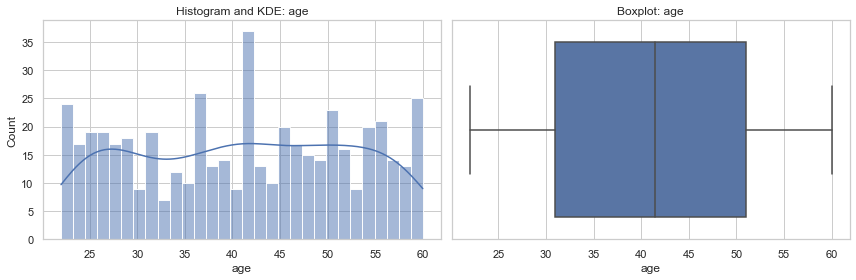

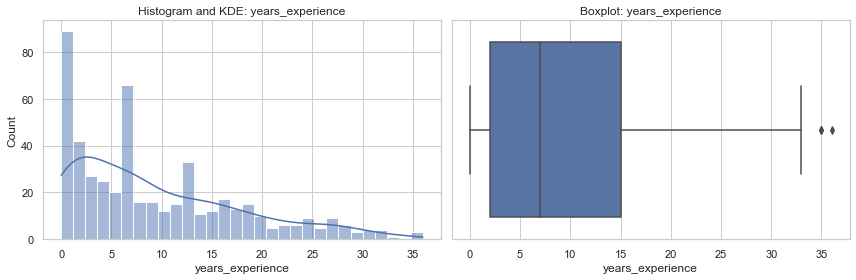

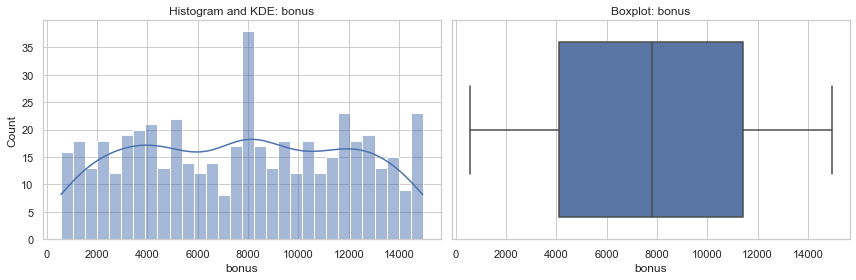

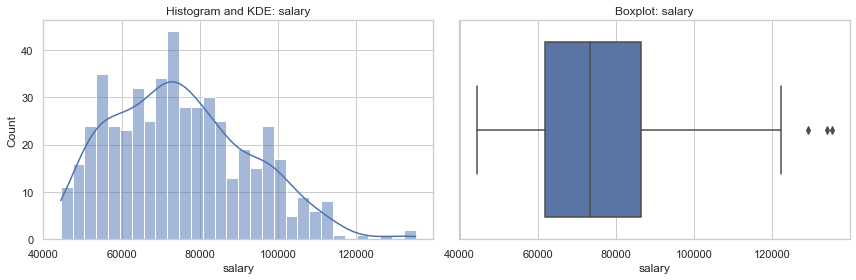

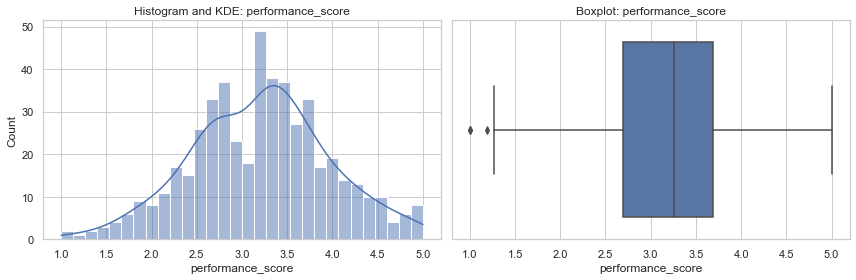

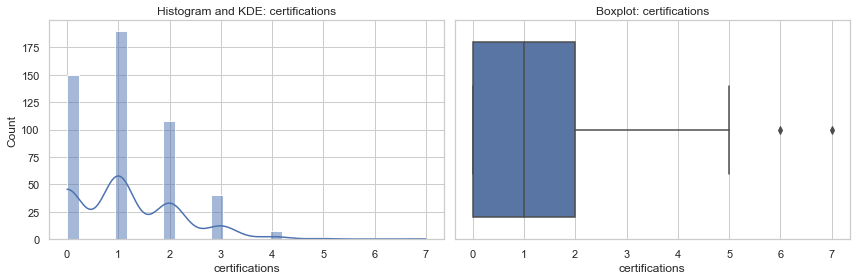

In [5]:
# Explanation: Univariate plots show the distribution of a single variable.
# Histograms reveal the distribution (counts) and kernel density estimate (KDE) shows smoothed density.
# Boxplots highlight median, quartiles, and potential outliers (whiskers).

numeric_cols = ['age','years_experience','bonus','salary','performance_score','certifications']
numeric_cols = [c for c in numeric_cols if c in df.columns]  # ensure columns exist

for col in numeric_cols:
    # Create a figure with two subplots side-by-side: histogram (left) and boxplot (right)
    plt.figure(figsize=(12,4))  # set the size of the figure (width, height in inches)
    
    # Histogram with seaborn: histplot uses matplotlib under the hood
    plt.subplot(1,2,1)  # left subplot
    sns.histplot(df[col].dropna(), kde=True, bins=30)  # dropna to avoid plotting NaNs
    plt.title(f'Histogram and KDE: {col}')
    plt.xlabel(col)
    
    # Boxplot: shows median and IQR and potential outliers
    plt.subplot(1,2,2)  # right subplot
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot: {col}')
    
    plt.tight_layout()  # adjust subplot params to fit in figure area
    plt.show()  # render the figure


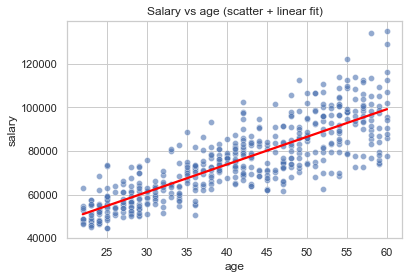

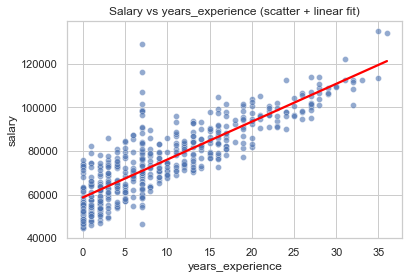

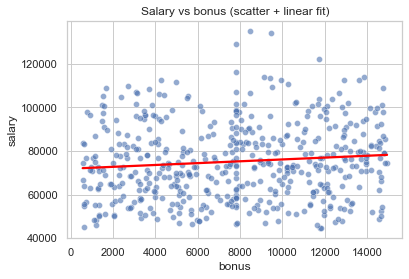

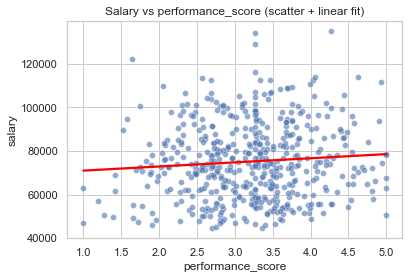

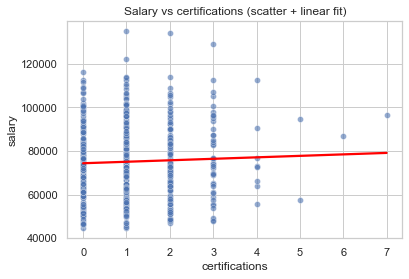

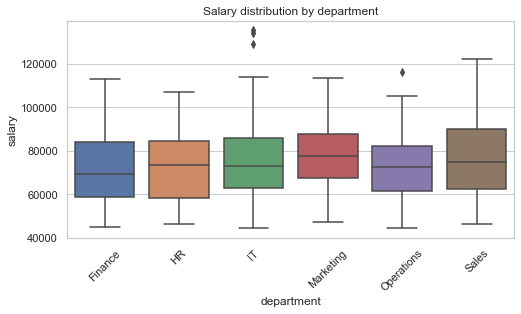

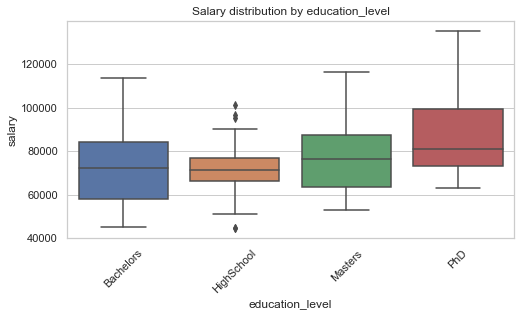

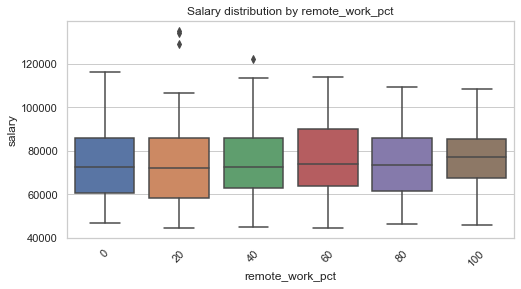

In [6]:
# Explanation: Bivariate analysis inspects the relationship between two variables.
# For regression, we focus on salary (target) vs other features (numeric & categorical).

# Salary vs numeric features: scatter plots and regression line (lowess optional)
num_feats = ['age','years_experience','bonus','performance_score','certifications']
num_feats = [c for c in num_feats if c in df.columns]

for feat in num_feats:
    plt.figure(figsize=(6,4))
    # scatterplot shows points (x=feature, y=salary)
    sns.scatterplot(x=feat, y='salary', data=df, alpha=0.6)
    # seaborn's regplot fits and plots a linear regression line by default for visualization
    sns.regplot(x=feat, y='salary', data=df, scatter=False, ci=None, line_kws={'color':'red'})
    plt.title(f'Salary vs {feat} (scatter + linear fit)')
    plt.show()

# Salary vs categorical features: boxplots (salary distribution per category)
cat_feats = ['department','education_level','remote_work_pct']
cat_feats = [c for c in cat_feats if c in df.columns]
for feat in cat_feats:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=feat, y='salary', data=df, order=sorted(df[feat].unique()))
    plt.title(f'Salary distribution by {feat}')
    plt.xticks(rotation=45)
    plt.show()


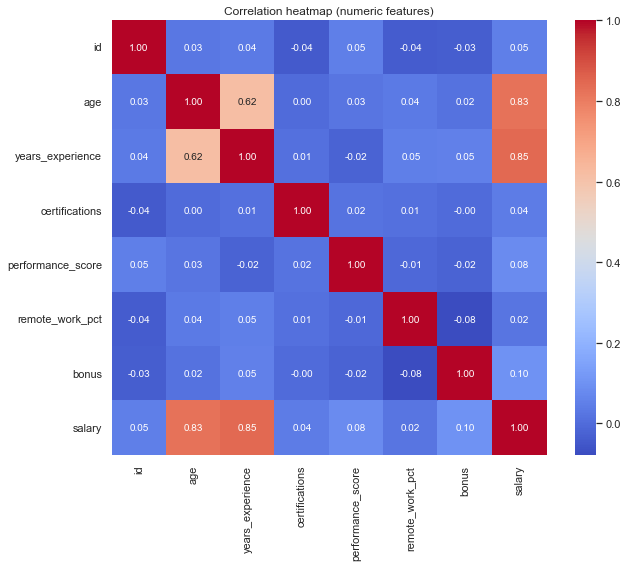

In [7]:
# Explanation: Correlation matrix shows pairwise Pearson correlation coefficients for numeric variables.
# Values in correlation matrix range from -1 (perfect negative) to +1 (perfect positive).
# A correlation near 0 indicates no linear relationship.

numeric_for_corr = df.select_dtypes(include=[np.number])  # select numeric columns only
plt.figure(figsize=(10,8))
corr = numeric_for_corr.corr()  # DataFrame.corr computes pairwise correlations (default method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation heatmap (numeric features)')
plt.show()


### InterQuartile Range (IQR)

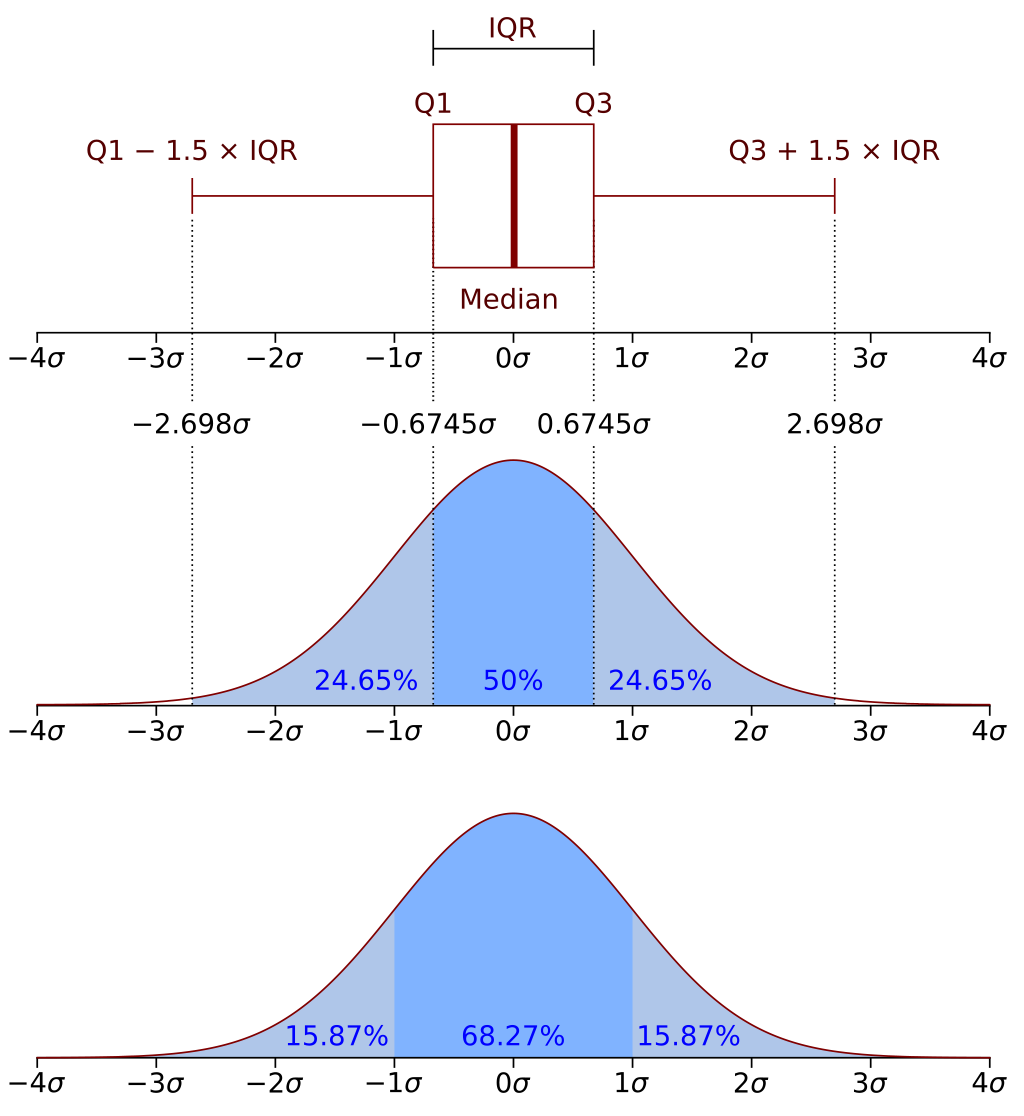

In [8]:
# Explanation: Detect outliers using the IQR (Interquartile Range) rule.

# IQR = Q3 - Q1; typical bounds are [Q1 - 1.5*IQR, Q3 + 1.5*IQR]. Observations outside these bounds are potential outliers.

def iqr_bounds(series, k=1.5):
    # Q1 is the 25th percentile; Q3 is the 75th percentile
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

# Apply IQR method to key numeric columns and report counts of outliers
cols_to_check = ['salary','bonus','years_experience','performance_score']
cols_to_check = [c for c in cols_to_check if c in df.columns]

for c in cols_to_check:
    s = df[c].dropna()
    lower, upper = iqr_bounds(s)
    outliers = s[(s < lower) | (s > upper)]
    print(f"{c}: lower={lower:.2f}, upper={upper:.2f}, outliers_count={len(outliers)}")

# Optionally, remove extreme outliers by filtering (commented out by default)
# for c in cols_to_check:
#     lower, upper = iqr_bounds(df[c].dropna())
#     df = df[(df[c] >= lower) & (df[c] <= upper)]
# print('Shape after optional outlier removal:', df.shape)


salary: lower=25227.38, upper=123080.38, outliers_count=3
bonus: lower=-6847.62, upper=22399.38, outliers_count=0
years_experience: lower=-17.50, upper=34.50, outliers_count=3
performance_score: lower=1.21, upper=5.18, outliers_count=3


In [9]:
# Explanation: Create derived features that may improve model predictive power.
# 1) Tenure in years (from hire_date to today). We use (today - hire_date).days / 365.
if 'hire_date' in df.columns:
    today = pd.Timestamp.today()
    # tenure_days is an integer number of days of tenure
    df['tenure_days'] = (today - df['hire_date']).dt.days
    # tenure_years is a float (approximate number of years)
    df['tenure_years'] = (df['tenure_days'] / 365).round(2)

# 2) Experience bins (categorical): group years_experience into buckets
if 'years_experience' in df.columns:
    bins = [ -1, 1, 5, 10, 20, 50 ]  # bucket edges: 0-1,2-5,6-10,11-20,21+
    labels = ['0-1','2-5','6-10','11-20','21+']
    df['experience_bin'] = pd.cut(df['years_experience'], bins=bins, labels=labels)

# 3) Education encoding example (we'll later one-hot encode for modeling)
# pd.get_dummies will be used during modeling prep; here we just show the distribution
if 'education_level' in df.columns:
    print('Education level distribution:')
    print(df['education_level'].value_counts())

# 4) Interaction example: performance_score * certifications (a simple interaction feature)
if 'performance_score' in df.columns and 'certifications' in df.columns:
    df['perf_times_cert'] = df['performance_score'] * df['certifications']

display(df.head())


Education level distribution:
Bachelors     299
Masters       141
PhD            36
HighSchool     24
Name: education_level, dtype: int64


,id,age,years_experience,department,education_level,certifications,performance_score,remote_work_pct,bonus,hire_date,salary,tenure_days,tenure_years,experience_bin,perf_times_cert
0,1,24,2.0,Finance,PhD,1,3.50,0,6490.0,2009-11-29,68622,5775,15.82,2-5,3.50
1,2,50,13.0,HR,Bachelors,2,3.29,100,14567.0,2016-12-18,84421,3199,8.76,11-20,6.58
2,3,56,22.0,Sales,Bachelors,1,3.89,40,6214.0,2018-05-06,98333,2695,7.38,21+,3.89
3,4,60,23.0,HR,Bachelors,0,3.12,20,13092.0,2014-01-20,101913,4262,11.68,21+,0.00
4,5,39,9.0,IT,Bachelors,2,2.77,40,10858.0,2017-07-16,70554,2989,8.19,6-10,5.54


In [10]:
# Explanation: Prepare feature matrix X and target vector y for regression modeling.
# Steps: select features, encode categorical variables, scale numeric variables.

# 1) Choose a reasonable set of features for regression
features = ['age','years_experience','certifications','performance_score','remote_work_pct','bonus','tenure_years','perf_times_cert']
# include experience_bin and education_level as categorical features (one-hot)
categorical = ['experience_bin','education_level','department']

# Ensure features exist in DataFrame; filter lists
features = [f for f in features if f in df.columns]
categorical = [c for c in categorical if c in df.columns]

# 2) Create a working DataFrame for modeling
df_model = df[features + categorical + ['salary']].copy()

# 3) Handle missing values in df_model (simplest strategy: median for numeric, mode for categorical)
for col in df_model.select_dtypes(include=[np.number]).columns:
    df_model[col] = df_model[col].fillna(df_model[col].median())

for col in categorical:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].mode().iloc[0])

# 4) One-hot encode categorical features using pandas get_dummies (drop_first avoids multicollinearity)
df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True)

# 5) Separate features X and target y
X = df_model.drop(columns=['salary'])
y = df_model['salary']

# 6) Feature scaling for numeric columns (StandardScaler: zero mean, unit variance)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()  # instantiate scaler object
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])  # fit on X and transform (returns numpy array)
print('Prepared X shape:', X.shape)


Prepared X shape: (500, 20)


In [11]:
# Explanation: Split data into training and testing sets.
# test_size=0.2 means 20% test, 80% train. random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])


Train size: 400 Test size: 100


In [12]:
# Explanation: Fit Ordinary Least Squares Linear Regression.
# 


lr = LinearRegression()  # instantiate model
lr.fit(X_train, y_train)  # fit model to training data (X_train, y_train)

# Predictions on the test set
y_pred = lr.predict(X_test)

# Model coefficients and intercept
coefficients = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
print('Intercept (bias term):', lr.intercept_)
print('\nTop coefficients by absolute magnitude:')
print(coefficients.head(15))


Intercept (bias term): 74884.3707851138

Top coefficients by absolute magnitude:
years_experience              10141.338864
age                            7919.109459
education_level_PhD            4394.316736
education_level_Masters        3149.805696
performance_score              1518.730334
education_level_HighSchool    -1068.825018
bonus                          1031.800368
certifications                  854.073411
remote_work_pct                -317.506461
experience_bin_21+                0.026938
tenure_years                     -0.026397
department_HR                     0.021961
department_IT                    -0.020830
perf_times_cert                  -0.015190
department_Marketing              0.011845
dtype: float64


In [13]:
# Explanation: Evaluate model performance using common regression metrics.
# MAE (Mean Absolute Error) is average absolute difference between predicted and actual.
# MSE (Mean Squared Error) penalizes larger errors more strongly; RMSE is sqrt(MSE) in same units as target.
# R^2 is coefficient of determination: proportion of variance explained by the model (1.0 is perfect).

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.4f}')


MAE: 2842.12
MSE: 46362683.51
RMSE: 6809.01
R^2: 0.8378


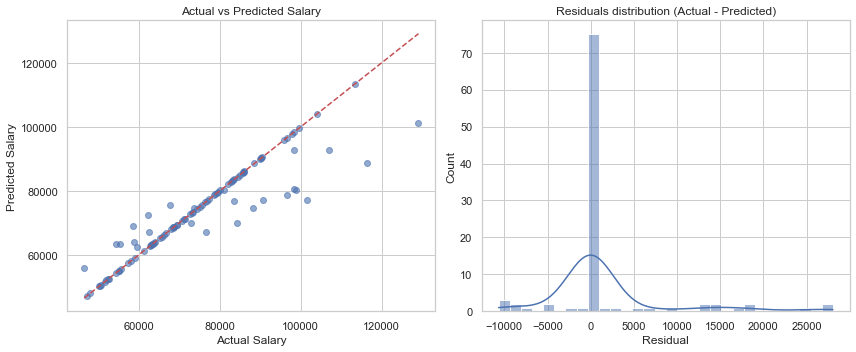

In [14]:
# Explanation: Visual diagnostics - Predicted vs Actual scatter and residuals histogram.
plt.figure(figsize=(12,5))

# Left: Predicted vs Actual scatter
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line y=x
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salary')

# Right: Residuals histogram (errors)
residuals = y_test - y_pred
plt.subplot(1,2,2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals distribution (Actual - Predicted)')
plt.xlabel('Residual')

plt.tight_layout()
plt.show()


In [15]:
# Explanation: Save cleaned dataset and trained model to the output folder.
# Save cleaned (post-processed) dataset
cleaned_path = OUTPUT_DIR / 'cleaned_regression_dataset.csv'
df.to_csv(cleaned_path, index=False)
print('Saved cleaned dataset to', cleaned_path)

# Save model and scaler (we save the pipeline pieces separately)
model_path = OUTPUT_DIR / 'linear_regression_model.joblib'
scaler_path = OUTPUT_DIR / 'scaler.joblib'
joblib.dump(lr, model_path)  # persist trained model to disk
joblib.dump(scaler, scaler_path)  # persist fitted scaler to disk
print('Saved model to', model_path)
print('Saved scaler to', scaler_path)


Saved cleaned dataset to output\cleaned_regression_dataset.csv
Saved model to output\linear_regression_model.joblib
Saved scaler to output\scaler.joblib
